## Imports

In [2]:
import sys
sys.path.append("../")

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt

from monai.inferers import sliding_window_inference
from monai.config import print_config


import torch
#import pytorch_lightning
import lightning
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from monai_unet import Net


In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)
torch.backends.cudnn.benchmark = True
print_config()

device =  cuda
MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: c:\awilde\<username>a\LTU\DataMining\DataMiningProjectWork\.conda\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.1+cu124
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml ver

In [5]:
PATH = "C:\\awilde\\britta\\LTU\\DataMining\\Data\\Task02_Heart\\"

## Run the training

In [6]:
torch.set_float32_matmul_precision('medium')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
# initialise the LightningModule
net = Net(device = device, datadir= PATH)

# set up checkpoints
# TODO model callback set when val_loss lowest
checkpoint_callback = ModelCheckpoint(dirpath="./heart_data_lightning_models/", filename='{epoch}-{val_loss:.2f}-{val_dice:.2f}', monitor="val_dice", mode="max")
early_stopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
max_epochs = 120

# initialise Lightning's trainer.
trainer = lightning.Trainer(
    devices=[0],
    max_epochs=max_epochs,
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=4,
)

# train
trainer.fit(net)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\awilde\britta\LTU\DataMining\DataMiningProjectWork\.conda\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | _model        | UNet       | 4.8 M  | train
1 | loss_function | DiceCELoss | 0      | train
-----------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.236    Total estimated model par

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:06<00:00,  0.33it/s]current epoch: 0 current val_loss: 1.4460606575012207 current mean dice: 0.0074
best mean dice: 0.0074 at epoch: 0
Epoch 0: 100%|██████████| 32/32 [00:46<00:00,  0.69it/s, v_num=5]          current epoch: 0 current val_loss: 1.3693976402282715 current mean dice: 0.0205
best mean dice: 0.0205 at epoch: 0
Epoch 1: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s, v_num=5]current epoch: 1 current val_loss: 1.2077213525772095 current mean dice: 0.0388
best mean dice: 0.0388 at epoch: 1
Epoch 2: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s, v_num=5]current epoch: 2 current val_loss: 1.1375813484191895 current mean dice: 0.0701
best mean dice: 0.0701 at epoch: 2
Epoch 3: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s, v_num=5]current epoch: 3 current val_loss: 1.062110424041748 current mean dice: 0.1165
best mean dice: 0.1165 at epoch: 3
Epoch 4: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s, v_num=5]current epoch: 4

## Plot the loss and dice metric

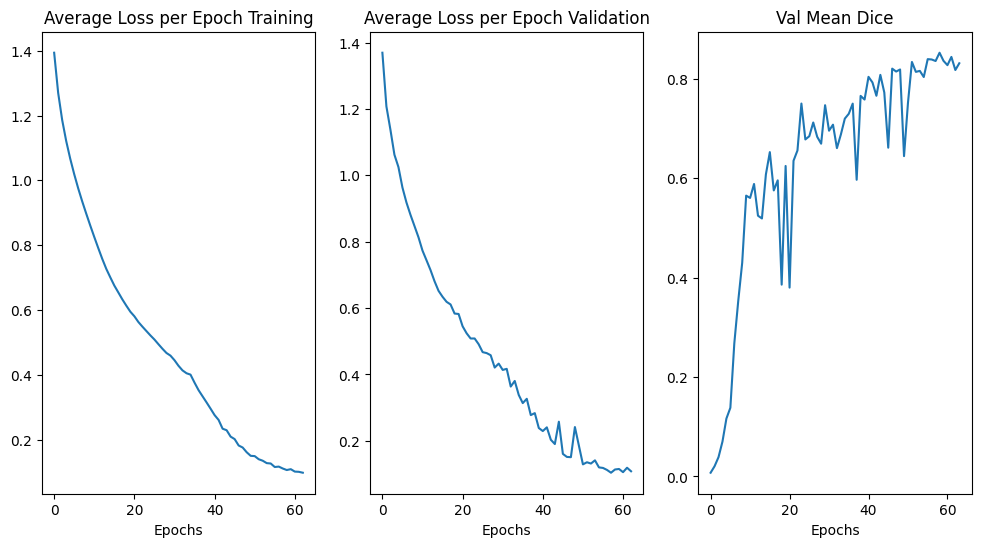

In [8]:
plt.figure("train", (12, 6))
plt.subplot(1, 3, 1)
plt.title("Average Loss per Epoch Training")
x = [i for i in range(0,len(net.epoch_train_loss))]
y = net.epoch_train_loss
plt.xlabel("Epochs")
plt.plot(x, y)
plt.subplot(1, 3, 2)
plt.title("Average Loss per Epoch Validation")
# skip first epoch for validation loss as it is very high
x = [i for i in range(0,len(net.epoch_val_loss)-1)]
y = net.epoch_val_loss[1:]
plt.xlabel("Epochs")
plt.plot(x, y)
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice")
x = [i for i in range(0,len(net.metric_values))]
y = net.metric_values
plt.xlabel("Epochs")
plt.plot(x, y)
plt.show()

## Test model on unseen data

In [9]:
# this will print the avg loss and dice metric on the test set
trainer.test()

c:\awilde\britta\LTU\DataMining\DataMiningProjectWork\.conda\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]
Restoring states from the checkpoint path at C:\awilde\britta\LTU\DataMining\DataMiningProjectWork\Heart_monai\heart_data_lightning_models\epoch=57-val_loss=0.10-val_dice=0.85.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\awilde\britta\LTU\DataMining\DataMiningProjectWork\Heart_monai\heart_data_lightning_models\epoch=57-val_loss=0.10-val_dice=0.85.ckpt


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


[{}]

## Load model from checkpoint to plot predictions

In [10]:
model = Net.load_from_checkpoint(checkpoint_callback.best_model_path, device = device, datadir = PATH)
model.eval()
model.to(device)
model.prepare_data()

Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


In [11]:
# make predictions
images = []
outputs = []
labels = []
test_loader = model.test_dataloader()
for test_data in test_loader: 
    val_inputs, val_labels = (
        test_data["image"].to(device),
        test_data["label"].to(device),
    )
    images.append(val_inputs)
    outputs.append(model.forward(val_inputs))
    labels.append(val_labels)

In [12]:
def plot_predictions(idx_of_image, outputs, images, labels):
    # Assuming outputs, labels, and images are your variables
    output = outputs[idx_of_image]
    label = labels[idx_of_image][0][0]
    image = images[idx_of_image][0][0]

    # Set the slice range from 45 to 50
    slice_start = 45
    slice_end = 55

    # Calculate the number of slices
    num_slices = slice_end - slice_start

    # Create a subplot with 'num_slices' rows and 3 columns
    plt.figure(figsize=(15, 5 * num_slices))

    for i in range(num_slices):
        # Increment the slice index
        current_slice = slice_start + i
        
        # Plot the Model Output
        plt.subplot(num_slices, 3, 3 * i + 1)
        with torch.no_grad():
            plt.imshow(torch.argmax(output.cpu(), dim=1)[0, :, :, current_slice])
        plt.title(f'Model Output - Slice {current_slice}')

        # Plot the Label
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.imshow(label.cpu()[:, :, current_slice])
        plt.title(f'Label - Slice {current_slice}')

        # Plot the Input Image
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.imshow(image.cpu()[:, :, current_slice])
        plt.title(f'Input Image - Slice {current_slice}')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plots
    plt.show()

## Plot predictions

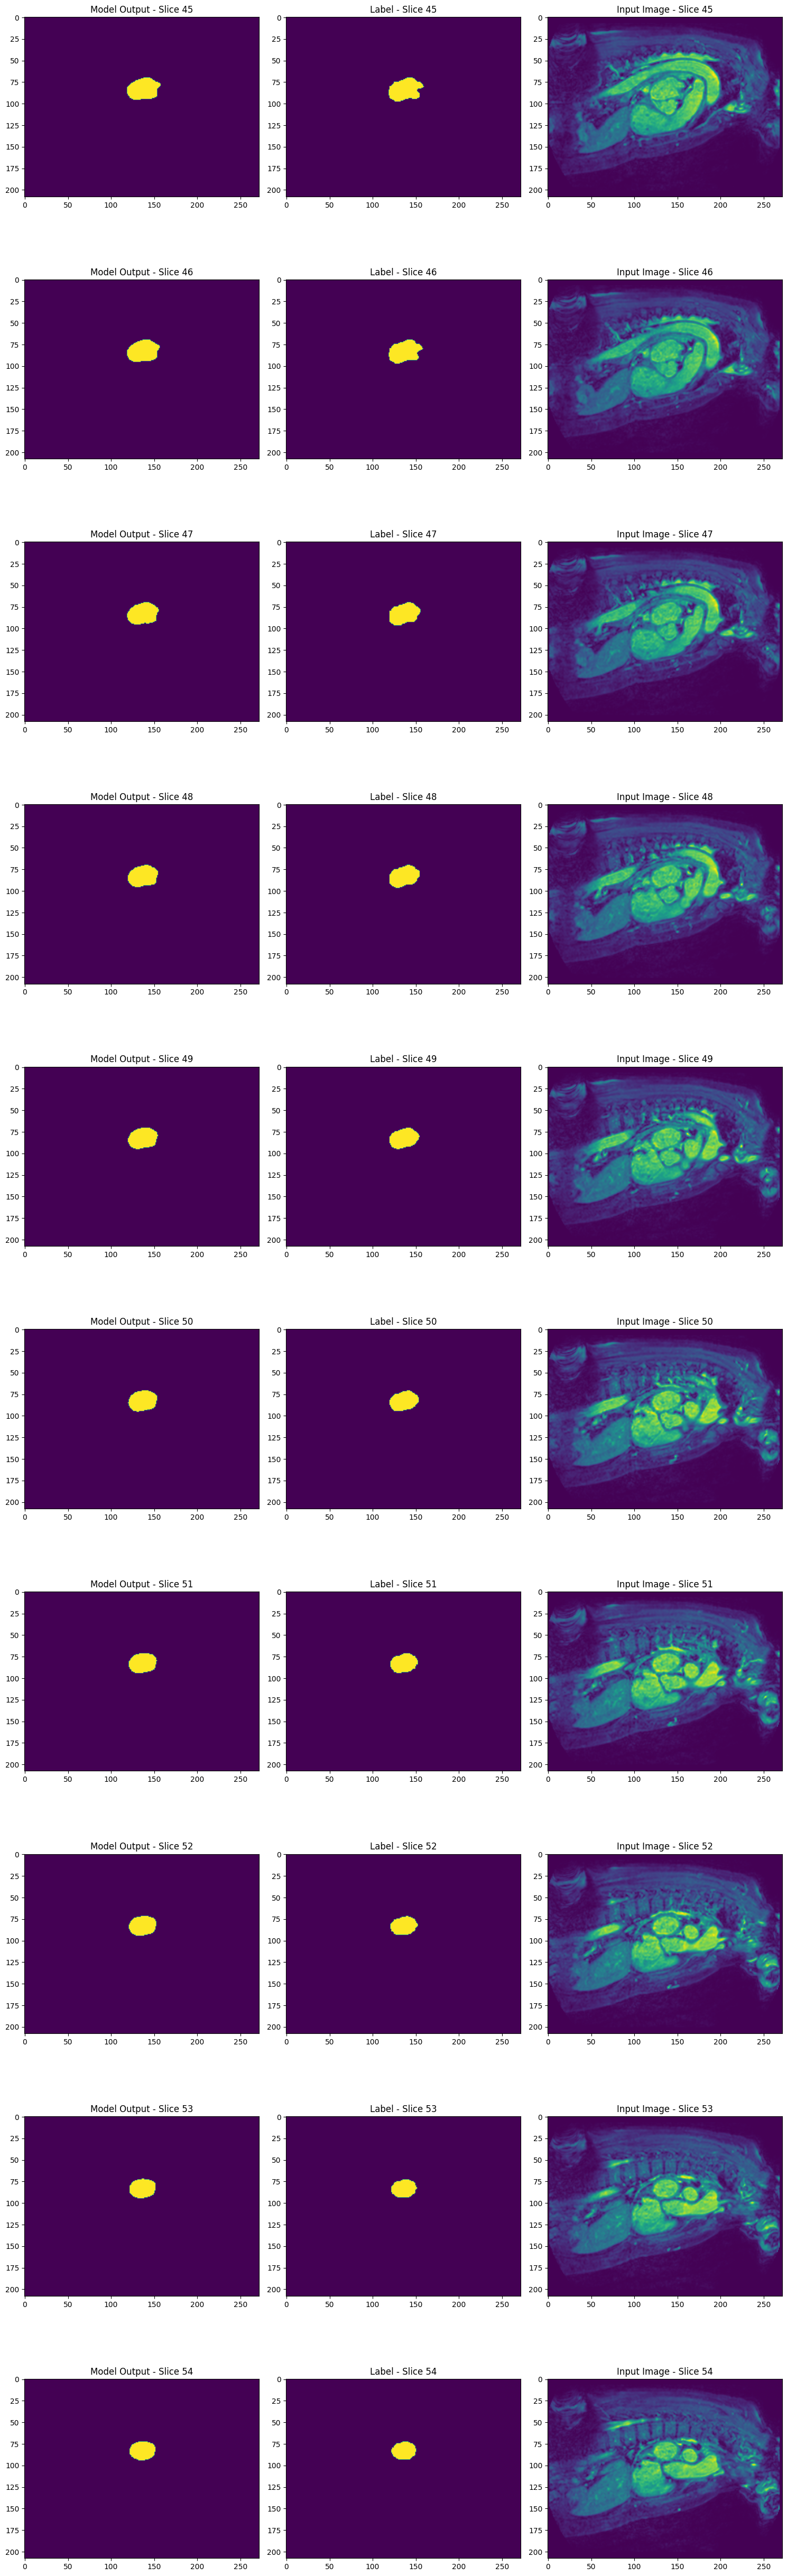

In [13]:
plot_predictions(0, outputs, images, labels)

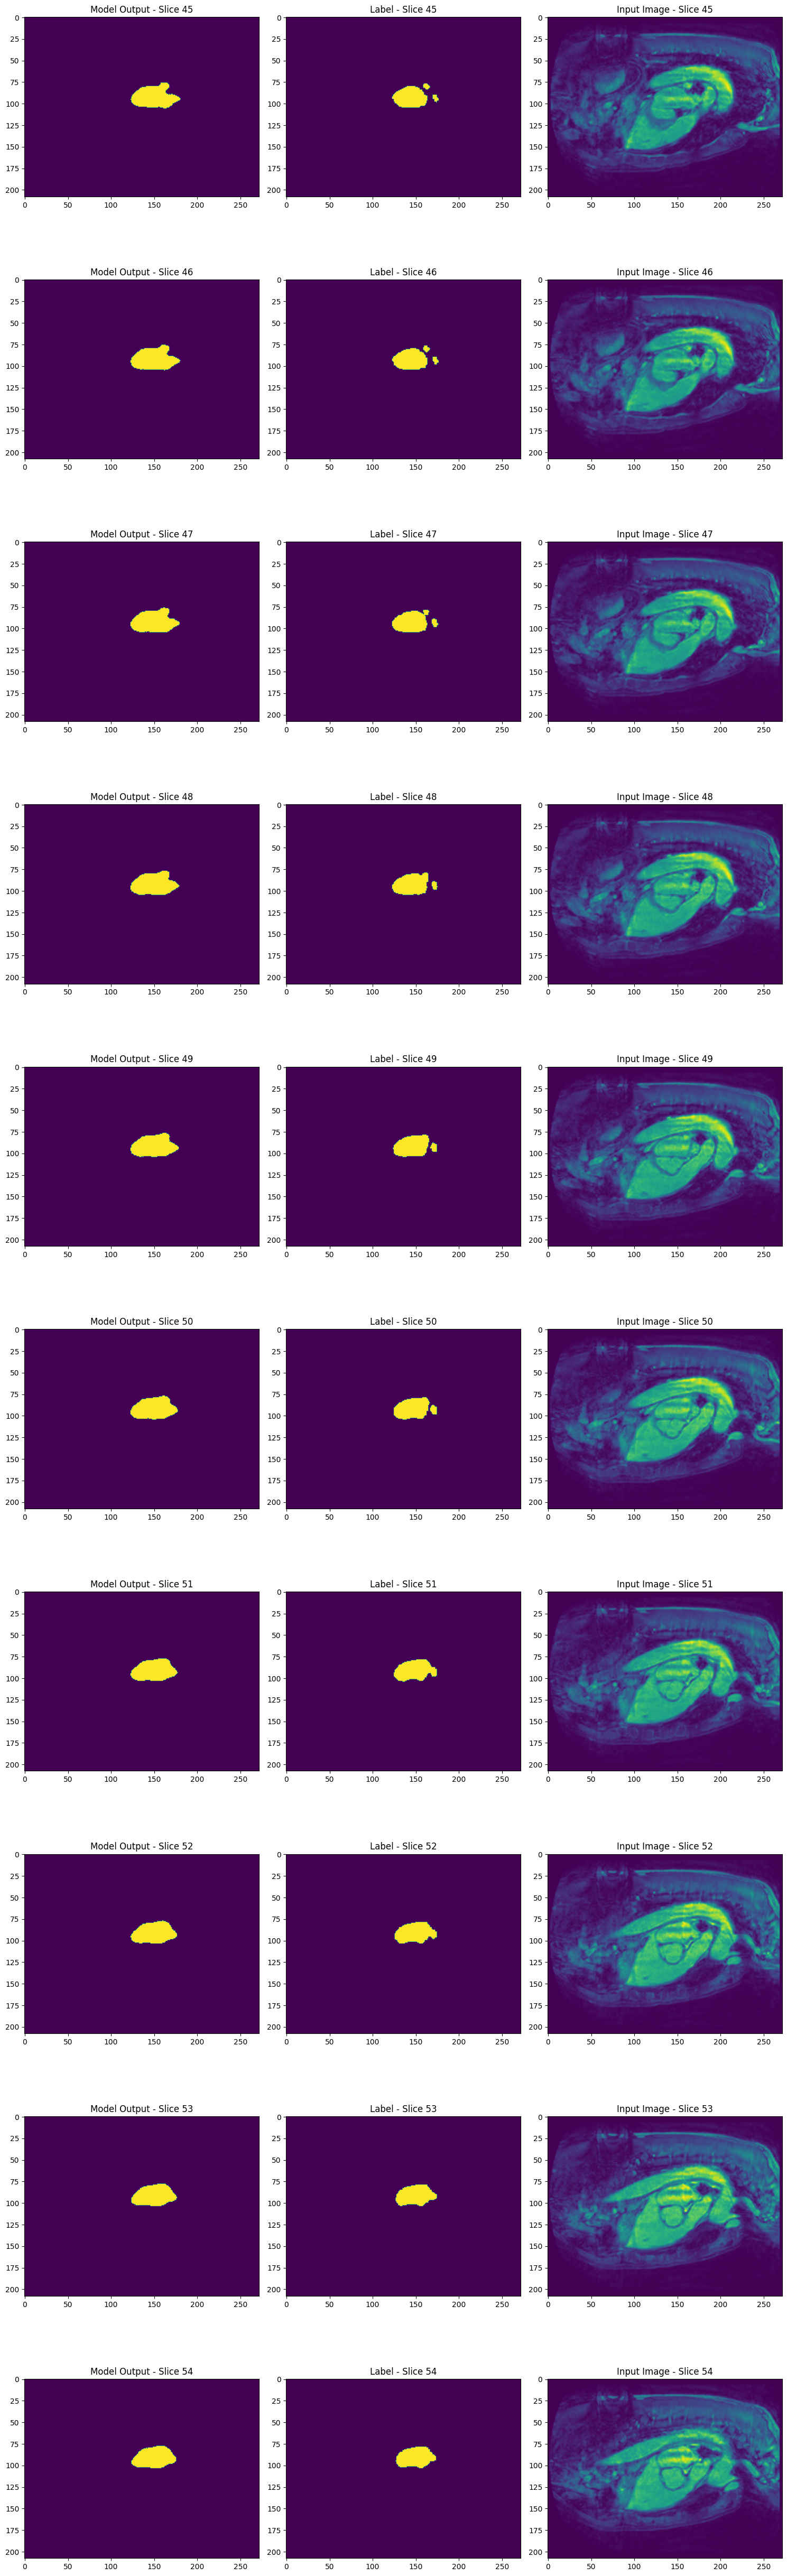

In [14]:
plot_predictions(1, outputs, images, labels)